Handwritten Text Recognition (HTR) is a Sequence-to-sequence (Seq2Seq) task, which is a specialized form of Structured Output that goes beyond simple image classification.


In [60]:
import numpy as np
import pandas as pd

In [67]:
# Loading the tsv
train_df = pd.read_csv("./archive/train.tsv", sep="\t", header=None)
test_df = pd.read_csv("./archive/test.tsv", sep="\t", header=None)
# val_df = pd.read_csv("./archive/test.tsv", sep="\t", header=None)

# val_df.columns = ["filename", "line"]
train_df.columns = ["filename", "line"]
test_df.columns = ["filename", "line"]

train_df

,filename,line
0,aa1.png,Молдова
1,aa1007.png,продолжила борьбу
2,aa101.png,разработанные
3,aa1012.png,Плачи
4,aa1013.png,Гимны богам
...,...,...
72281,yob20539.png,Ответственность в/сл-
72282,yob20543.png,независимо
72283,yob20544.png,от воинского звания
72284,yob20545.png,воинской


In [68]:
# Preprocessing
def tokenize(line):
    line = line.lower()
    tokens = line.split()
    return tokens


# Identify rows with missing values
missing_vals_rows = train_df[train_df['line'].isna()]
# 63652	yob3873.png	NaN
# 64127	yob4721.png	NaN

# Get rid of rows with NaN values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
# val_df.dropna(inplace=True)

# Get rid of bad rows containing latin or non-cyrillic chars
print("Bad samples containing non-cyrillic letters:\n")
print(train_df.iloc[37735], end='\n\n')
print(train_df.iloc[47799], end='\n\n')
print(train_df.iloc[65611], end='\n\n')

train_df.drop(index=37735, inplace=True)
train_df.drop(index=47799, inplace=True)
train_df.drop(index=65611, inplace=True)

# Reset index, to generate new indexing
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
# val_df.reset_index(drop=True, inplace=True)

Bad samples containing non-cyrillic letters:

filename    dem35055.png
line                 ИhМ
Name: 37735, dtype: object

filename      pe4578.png
line        R-эффективна
Name: 47799, dtype: object

filename    yob7358.png
line         применения
Name: 65613, dtype: object



In [69]:
print(train_df.iloc[37735])

filename    dem35057.png
line               кагра
Name: 37735, dtype: object


In [70]:
train_df["tokens"] = train_df["line"].apply(tokenize)
test_df["tokens"] = test_df["line"].apply(tokenize)

train_df

,filename,line,tokens
0,aa1.png,Молдова,[молдова]
1,aa1007.png,продолжила борьбу,"[продолжила, борьбу]"
2,aa101.png,разработанные,[разработанные]
3,aa1012.png,Плачи,[плачи]
4,aa1013.png,Гимны богам,"[гимны, богам]"
...,...,...,...
72276,yob20539.png,Ответственность в/сл-,"[ответственность, в/сл-]"
72277,yob20543.png,независимо,[независимо]
72278,yob20544.png,от воинского звания,"[от, воинского, звания]"
72279,yob20545.png,воинской,[воинской]


In [6]:
# Build a vocab
import unicodedata

def build_char_vocab(df, text_col='line', lowercase=True, add_blank=True, add_unseen=True):
    chars = set()
    for index, text in df[text_col].items():
        if not isinstance(text, str):
            continue

        # normalize unicode (important for cyrillic)
        # bc these chars have multiple valid ways to encode a single visual
        # character, 'NFC' - Normalization Form C
        text = unicodedata.normalize('NFC', text)
        text = text.lower() if lowercase else text

        # update the character set (including punctuation and spaces)
        chars.update(list(text))
    
    sorted_chars = sorted(chars)
    
    # Build mappings
    char2idx = {}
    idx = 0

    # Start by adding special symbols
    if add_blank:
        char2idx['<BLANK>'] = idx
        idx += 1

    for ch in sorted_chars:
        char2idx[ch] = idx
        idx += 1

    if add_unseen:
        char2idx['<UNK>'] = idx

    # Build reverse mapping
    idx2char = {val: key for key, val in char2idx.items()}

    print(f"Vocabulary successfully built: {len(char2idx)} total characters")

    return char2idx, idx2char

char2idx, idx2char = build_char_vocab(df=train_df, text_col='line')

print("char2idx vocab: ", char2idx)

Vocabulary successfully built: 69 total characters
char2idx vocab:  {'<BLANK>': 0, ' ': 1, '!': 2, '"': 3, '%': 4, "'": 5, '(': 6, ')': 7, '+': 8, ',': 9, '-': 10, '.': 11, '/': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, ':': 23, ';': 24, '=': 25, '?': 26, '[': 27, ']': 28, 'c': 29, 'x': 30, 'y': 31, '«': 32, '»': 33, 'а': 34, 'б': 35, 'в': 36, 'г': 37, 'д': 38, 'е': 39, 'ж': 40, 'з': 41, 'и': 42, 'й': 43, 'к': 44, 'л': 45, 'м': 46, 'н': 47, 'о': 48, 'п': 49, 'р': 50, 'с': 51, 'т': 52, 'у': 53, 'ф': 54, 'х': 55, 'ц': 56, 'ч': 57, 'ш': 58, 'щ': 59, 'ъ': 60, 'ы': 61, 'ь': 62, 'э': 63, 'ю': 64, 'я': 65, 'ё': 66, '№': 67, '<UNK>': 68}


### Encoding and decoding for characters

In [7]:
def text_to_indices(text, char2idx):
    text = unicodedata.normalize('NFC', text).lower()
    indices = []
    for ch in text:
        if ch in char2idx and ch != '<BLANK>':
            indices.append(char2idx[ch])
        else:
            indices.append(char2idx['<UNK>'])
    return indices

def indices_to_text(indices, idx2char):
    text = ""
    for i in indices:
        text += idx2char[i] if idx2char[i] != '<BLANK>' else ''
    return text


# The <BLANK> is reserved for CTC, <UKN> for unseen chars

sample = "Привет!"
encoded = text_to_indices(sample, char2idx)
decoded = indices_to_text(encoded, idx2char)

print(sample, "->", encoded, "->", decoded)


Привет! -> [49, 50, 42, 36, 39, 52, 2] -> привет!


### Subset of the train_df
To ease the task, we first try to feed our model single word input that should correspond to a single output. For that reason we create another dataset which is a subset of **train_df** (similarly, with test_df)

In [71]:
# # Filter
# single_token_train_df = train_df[train_df["tokens"].apply(len) == 1]
# single_token_train_df.reset_index(drop=True, inplace=True)
# single_token_train_df

,filename,line,tokens
0,aa1.png,Молдова,[молдова]
1,aa101.png,разработанные,[разработанные]
2,aa1012.png,Плачи,[плачи]
3,aa1017.png,(вспомнить,[(вспомнить]
4,aa1018.png,миф,[миф]
...,...,...,...
64972,yob20531.png,бедствий,[бедствий]
64973,yob20534.png,обст-ах,[обст-ах]
64974,yob20535.png,исп-ют,[исп-ют]
64975,yob20543.png,независимо,[независимо]


In [8]:
# For testing purposes:
def depict(image, label_tensor, label_str):
    image_copy = image.squeeze(0)
    plt.imshow(image_copy, cmap="gray")
    plt.title(label_str)

Batching: All images in a batch must have the exact same shape (e.g., 1×64×W 
max).



In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# from torchvision.transforms import ToTensor

import unicodedata
import cv2
from matplotlib import pyplot as plt
import os
from IPython.display import Image

%matplotlib inline


def resize_with_aspect(np_image, target_height):
    if np_image is None:
        return None

    aspect_ratio = target_height / np_image.shape[0]
    target_width = int(np_image.shape[1] * aspect_ratio)
    dim = (target_width, target_height)
    image = cv2.resize(np_image, dsize=dim, interpolation=cv2.INTER_AREA)
    return image

def pad_to_width(np_image, max_width):
    orig_width = np_image.shape[1]
    delta_w = max_width - orig_width
    if delta_w > 0:
        return cv2.copyMakeBorder(
            src=np_image, top=0, bottom=0, left=0,
            right=delta_w,  # Padding only from the right side
            borderType=cv2.BORDER_CONSTANT,
            value=0 # grayscale black padding
        )
    return np_image


class CyrillicHandwritingDataset(Dataset):
    def __init__(self, dataframe, images_dir, image_height=64, transform=None, char2idx=None):
        self.data = dataframe
        self.images_dir = images_dir
        self.image_height = image_height
        self.transform = transform  # convert an image to a tensor
        self.char2idx = char2idx
        self.labels = [
            ' '.join(tokens) if isinstance(tokens, list) else tokens
            for tokens in dataframe['tokens']
        ]
    
        # Load and resize images
        self.images = self._load_and_resize_images()

        # Get max width for padding
        self.max_width = max(img.shape[1] for img in self.images)

        # Pad all resized images
        self.images = [
            pad_to_width(image, self.max_width) for image in self.images
        ]

    def _load_and_resize_images(self):
        """
        Loading and resizing with aspect
        """
        resized_images = []
        for index, row in self.data.iterrows():
            filename = row["filename"]
            image_path = os.path.abspath(os.path.join(self.images_dir, filename))
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Resize this image
            resized_image = resize_with_aspect(image, self.image_height)
            resized_images.append(resized_image)

        return resized_images

    def text_to_indices(self, text):
        text = unicodedata.normalize('NFC', text).lower()
        indices = []
        for ch in text:
            if ch in self.char2idx and ch != '<BLANK>':
                indices.append(self.char2idx[ch])
            else:
                indices.append(self.char2idx['<UNK>'])
        return indices
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image_tensor = self.transform(image)
        label_indices = self.text_to_indices(label)
        label_tensor = torch.tensor(label_indices, dtype=torch.long)
        
        return image_tensor, label_tensor, label



# Compose used to chain image transformations.
transform_pipeline = transforms.Compose([
    transforms.ToTensor()
    # TODO: possibly include a normalization step here once mean and std is known 
])

train_set = CyrillicHandwritingDataset(
    dataframe=train_df,
    images_dir="./archive/train/",
    image_height=64,
    transform=transform_pipeline,
    char2idx=char2idx
)

In [10]:
img, label_tensor, label_str = train_set[0]

print("Original label:", label_str)
print("Encoded:", label_tensor)
print("Image shape:", img.shape)

Original label: молдова
Encoded: tensor([46, 48, 45, 38, 48, 36, 34])
Image shape: torch.Size([1, 64, 748])


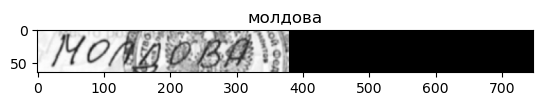

In [15]:
depict(*train_set[0])

In [15]:
from torch.utils.data import DataLoader


def cyrillic_collate_fn(batch):
    """
    batch: (image_tensor, label_tensor, label_str)
    """

    batch.sort(key=lambda x: x[0].shape[-1], reverse=True)

    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    label_strs = [item[2] for item in batch]
    images_padded = torch.stack(images, dim=0)
    # All labels concatenated
    labels_concat = torch.cat(labels)

    # Effective sequence lengths after CNN
    input_lengths = torch.full(
        size=(len(images),),
        fill_value=images_padded.shape[-1] // 4,
        dtype=torch.long
    )
    # Label lenght (number of characters)
    target_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)

    return images_padded, labels_concat, input_lengths, target_lengths, label_strs    

train_loader = DataLoader(
    train_set,
    batch_size=4,
    shuffle=False,
    collate_fn=cyrillic_collate_fn
)

In [16]:
batch = next(iter(train_loader))
images, labels_concat, input_lengths, target_lengths, label_strs = batch

print("Images:", images.shape)
print("Labels (concatenated):", labels_concat.shape)
print("Input lengths:", input_lengths)
print("Target lengths:", target_lengths)
print("First label (string):", label_strs[0])

Images: torch.Size([4, 1, 64, 748])
Labels (concatenated): torch.Size([42])
Input lengths: tensor([187, 187, 187, 187])
Target lengths: tensor([ 7, 17, 13,  5])
First label (string): молдова


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CRNN(nn.Module):
    def __init__(self, img_height, num_classes, hidden_size=256, num_rnn_layers=2):
        super(CRNN, self).__init__()

        # --- 1. CNN feature extractor ---
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),   # (B, 64, H, W)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # ↓ H/2, W/2

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (B, 128, H/2, W/2)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # ↓ H/4, W/4

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# (B, 256, H/4, W/4)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # compute feature size after CNN (height is fixed)
        conv_output_height = img_height // 4  # from pooling

        # --- 2. Recurrent part (BiLSTM) ---
        self.rnn = nn.LSTM(
            input_size=256 * conv_output_height,
            hidden_size=hidden_size,
            num_layers=num_rnn_layers,
            bidirectional=True,
            batch_first=False  # we’ll permute dims before feeding
        )

        # --- 3. Linear layer for classification ---
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 for bidirectional

    def forward(self, x):
        # x: (B, 1, H, W)
        conv_out = self.cnn(x)  # (B, C, H', W')

        B, C, H, W = conv_out.size()
        # flatten height dimension into channels for sequence modeling
        conv_out = conv_out.permute(3, 0, 1, 2)  # (W', B, C, H')
        conv_out = conv_out.reshape(W, B, C * H) # (T=W', B, C*H')

        # RNN expects (T, B, input_size)
        rnn_out, _ = self.rnn(conv_out)  # (T, B, 2*hidden_size)
        output = self.fc(rnn_out)        # (T, B, num_classes)

        # For CTC loss, we need log probabilities
        log_probs = F.log_softmax(output, dim=2)
        return log_probs


In [32]:
# assume: num_classes = len(char2idx)
num_classes = len(char2idx)
model = CRNN(img_height=64, num_classes=num_classes)

# take one batch
images, labels_concat, input_lengths, target_lengths, label_strs = next(iter(train_loader))
log_probs = model(images)

print("Input:", images.shape)
print("Output:", log_probs.shape)

Input: torch.Size([4, 1, 64, 748])
Output: torch.Size([187, 4, 69])


In [33]:
criterion = nn.CTCLoss(blank=char2idx['<BLANK>'], zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# (T, B, num_classes)
log_probs = model(images)
loss = criterion(log_probs, labels_concat, input_lengths, target_lengths)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"Loss: {loss.item():.4f}")


Loss: 89.0034


In [34]:
preds = log_probs.argmax(dim=2)  # shape: (T, B)
def greedy_decode(preds, idx2char):
    """
    preds: (T, B) tensor of indices
    """
    preds = preds.transpose(0, 1)  # (B, T)
    decoded_texts = []

    for pred in preds:
        # Collapse repeated characters and remove blanks
        prev_idx = None
        decoded = []
        for idx in pred:
            idx = idx.item()
            if idx != prev_idx and idx2char[idx] != '<BLANK>':
                decoded.append(idx2char[idx])
            prev_idx = idx
        decoded_texts.append(''.join(decoded))
    return decoded_texts


print(label_strs)
decoded = greedy_decode(preds, idx2char)
print("Predicted:", decoded)


['молдова', 'продолжила борьбу', 'разработанные', 'плачи']
Predicted: [":'«'«!'«'«'«'«'«'«'«'«'ш2,ш", ".'к2ш", ":'н'н'н'йн'н'н'н'н'м'ан'нй'н'н'ь»2,ш", '.».2ш']


In [81]:
# Test dataset
test_set = CyrillicHandwritingDataset(
    dataframe=test_df,
    images_dir="./archive/test/",
    image_height=64,
    transform=transform_pipeline,
    char2idx=char2idx
)

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

# Assuming you already have:
# - CyrillicHandwritingDataset
# - cyrillic_collate_fn
# - char2idx (dictionary)
# - idx2char (reverse mapping)
# - train_df, test_df cleaned (NaNs dropped)
# - transform_pipeline

# ==========================
# 1. Dataset & DataLoader
# ==========================
train_dataset = CyrillicHandwritingDataset(
    dataframe=train_df,
    images_dir="./archive/train/",
    image_height=64,
    transform=transform_pipeline,
    char2idx=char2idx
)

test_dataset = CyrillicHandwritingDataset(
    dataframe=test_df,
    images_dir="./archive/test/",
    image_height=64,
    transform=transform_pipeline,
    char2idx=char2idx
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=cyrillic_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=cyrillic_collate_fn)

# ==========================
# 2. Define CRNN Model
# ==========================
class CRNN(nn.Module):
    def __init__(self, num_classes, img_height=64):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),   # [B, 64, 64, W]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),          # [B, 64, 32, W/2]
            nn.Conv2d(64, 128, 3, 1, 1), # [B, 128, 32, W/2]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),          # [B, 128, 16, W/4]
        )

        self.rnn = nn.LSTM(
            input_size=128 * 16,  # flatten height dimension
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        B, C, H, W = x.size()
        x = x.permute(0, 3, 1, 2)  # [B, W, C, H]
        x = x.reshape(B, W, C * H) # flatten H
        x, _ = self.rnn(x)
        x = self.fc(x)
        x = x.permute(1, 0, 2)     # [T, B, num_classes] for CTC
        return x

# ==========================
# 3. Model, Loss, Optimizer
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(char2idx)
model = CRNN(num_classes=num_classes).to(device)

criterion = nn.CTCLoss(blank=char2idx['<BLANK>'], zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 4. Training Loop
# ==========================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels, input_lengths, target_lengths, _ in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # [T, B, num_classes]
        loss = criterion(outputs.log_softmax(2), labels, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

# ==========================
# 5. Greedy Decoding for CTC
# ==========================
def greedy_decode(output, idx2char):
    out = output.argmax(dim=2).permute(1, 0)  # [B, T]
    decoded_batch = []
    for seq in out:
        decoded = []
        prev = None
        for idx in seq:
            char = idx2char[idx.item()]
            if char != '<BLANK>' and char != prev:
                decoded.append(char)
            prev = char
        decoded_batch.append(''.join(decoded))
    return decoded_batch

# ==========================
# 6. Evaluation
# ==========================
def evaluate(model, loader, idx2char, device):
    model.eval()
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, labels, input_lengths, target_lengths, label_strs in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            preds = greedy_decode(outputs, idx2char)
            predictions.extend(preds)
            ground_truths.extend(label_strs)
    return predictions, ground_truths

# ==========================
# 7. Train & Test
# ==========================
EPOCHS = 10
for epoch in range(EPOCHS):
    loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {loss:.4f}")

# Evaluate after training
preds, gts = evaluate(model, test_loader, idx2char, device)

# ==========================
# 8. Inspect Predictions
# ==========================
for i in range(10):
    print(f"GT: {gts[i]}")
    print(f"Pred: {preds[i]}")
    print("-" * 40)


Training: 100%|████████████████████████████████████████████████████████████████████| 9036/9036 [11:19<00:00, 13.31it/s]


Epoch [1/10] - Train Loss: 3.3786


Training: 100%|████████████████████████████████████████████████████████████████████| 9036/9036 [11:17<00:00, 13.33it/s]


Epoch [2/10] - Train Loss: 2.3061


Training: 100%|████████████████████████████████████████████████████████████████████| 9036/9036 [11:07<00:00, 13.54it/s]


Epoch [3/10] - Train Loss: 0.9992


Training: 100%|████████████████████████████████████████████████████████████████████| 9036/9036 [10:55<00:00, 13.78it/s]


Epoch [4/10] - Train Loss: 0.6785


Training: 100%|████████████████████████████████████████████████████████████████████| 9036/9036 [10:48<00:00, 13.92it/s]


Epoch [5/10] - Train Loss: 0.5277


Training: 100%|████████████████████████████████████████████████████████████████████| 9036/9036 [10:42<00:00, 14.07it/s]


Epoch [6/10] - Train Loss: 0.4347


Training: 100%|████████████████████████████████████████████████████████████████████| 9036/9036 [10:36<00:00, 14.20it/s]


Epoch [7/10] - Train Loss: 0.3656


Training: 100%|████████████████████████████████████████████████████████████████████| 9036/9036 [10:40<00:00, 14.12it/s]


Epoch [8/10] - Train Loss: 0.3175


Training: 100%|████████████████████████████████████████████████████████████████████| 9036/9036 [10:42<00:00, 14.06it/s]


Epoch [9/10] - Train Loss: 0.2766


Training: 100%|████████████████████████████████████████████████████████████████████| 9036/9036 [10:35<00:00, 14.21it/s]


Epoch [10/10] - Train Loss: 0.2479


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 193/193 [00:13<00:00, 13.99it/s]

GT: ибо
Pred: ибо
----------------------------------------
GT: осталось
Pred: осталось
----------------------------------------
GT: поле
Pred: поле
----------------------------------------
GT: оптическое
Pred: опичское
----------------------------------------
GT: 1 класса
Pred: 1 класса
----------------------------------------
GT: г. ульяновск
Pred: 2. хлоеновси
----------------------------------------
GT: на место
Pred: на место
----------------------------------------
GT: паспорт
Pred: пспорг
----------------------------------------
GT: назначение
Pred: назначешие
----------------------------------------
GT: отправление
Pred: отправлешие
----------------------------------------


Connectionist Temporal Classification (CTC)
is a specialized loss function used to train the network for sequence recognition tasks where the alignment between the input (image) and the output (text) is unknown or variable, like handwriting or speech recognition.

In [76]:
torch.save(model.state_dict(), "crnn_cyrillic.pth")

Predicted: ибо


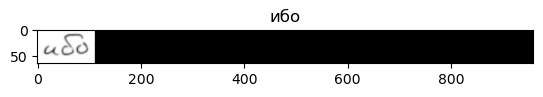

In [80]:
checkpoint_model = torch.load("crnn_cyrillic.pth")
# checkpoint_model.eval()

sample_image, _, _ = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)

# Forward pass
with torch.no_grad():
    output = model(sample_image)
    pred_text = greedy_decode(output, idx2char)[0]

depict(*test_dataset[0])
print(f"Predicted: {pred_text}")

### Cleaner version of the existing code

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm


# ==========================
# Dataset & DataLoader definition
# ==========================

train_dataset = CyrillicHandwritingDataset(
    dataframe=train_df,
    images_dir="./archive/train/",
    image_height=64,
    transform=transform_pipeline,
    char2idx=char2idx
)

test_dataset = CyrillicHandwritingDataset(
    dataframe=test_df,
    images_dir="./archive/test/",
    image_height=64,
    transform=transform_pipeline,
    char2idx=char2idx
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=cyrillic_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=cyrillic_collate_fn)

In [97]:
# ==========================
# CRNN (CNN + RNN) Model Class
# ==========================


class CRNN(nn.Module):
    def __init__(self, num_classes, img_height=64):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),   # [B, 64, 64, W]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),          # [B, 64, 32, W/2]
            nn.Conv2d(64, 128, 3, 1, 1), # [B, 128, 32, W/2]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),          # [B, 128, 16, W/4]
        )

        self.rnn = nn.LSTM(
            input_size=128 * 16,  # flatten height dimension
            hidden_size=256, # 256 -> 512
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        B, C, H, W = x.size()
        x = x.permute(0, 3, 1, 2)  # [B, W, C, H]
        x = x.reshape(B, W, C * H) # flatten H
        x, _ = self.rnn(x)
        x = self.fc(x)
        x = x.permute(1, 0, 2)     # [T, B, num_classes] for CTC
        return x


In [98]:
# ==========================
# Model, Loss, Optimizer
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(char2idx)
model = CRNN(num_classes=num_classes).to(device)

criterion = nn.CTCLoss(blank=char2idx['<BLANK>'], zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# Training Loop
# ==========================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels, input_lengths, target_lengths, _ in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # [T, B, num_classes]
        loss = criterion(outputs.log_softmax(2), labels, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

# ==========================
# Evaluation
# ==========================
def evaluate(model, loader, idx2char, device):
    model.eval()
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, labels, input_lengths, target_lengths, label_strs in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            preds = greedy_decode(outputs, idx2char)
            predictions.extend(preds)
            ground_truths.extend(label_strs)
    return predictions, ground_truths

When using CTC (Connectionist Temporal Classification), the model doesn't predict a label for each frame directly, instead it outputs a sequence of probabilities over the whole vocabulary for each time step in the feature map.
This output needs to be decoded into readable text.

Greedy decoding method means:
At each time step, simply pick the character with the highest probability
It's greedy because it doesn't look ahead or consider alternate sequences (unlike **beam search decoding**)

notes:
different searching techniques: greedy, exhaustive, beam (best pay-off)

In [99]:
# ==========================
# Greedy Decoding for CTC
# ==========================
def greedy_decode(output, idx2char):
    # output of a model: (T, B, C) - time_steps, batch_size, num_classes
    # get the index of the most probably class (hence dim=2, C)
    out = output.argmax(dim=2).permute(1, 0)  # [B, T]
    decoded_batch = []
    for seq in out:
        decoded = []
        prev = None
        for idx in seq:
            char = idx2char[idx.item()]
            if char != '<BLANK>' and char != prev:
                decoded.append(char)
            prev = char
        decoded_batch.append(''.join(decoded))
    return decoded_batch

In [100]:
# ==========================
# Train & Test
# ==========================
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=cyrillic_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=cyrillic_collate_fn)
EPOCHS = 50
for epoch in range(EPOCHS):
    loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {loss:.4f}")

# Evaluate after training
preds, gts = evaluate(model, test_loader, idx2char, device)

# ==========================
# Inspect Predictions
# ==========================
for i in range(10):
    print(f"GT: {gts[i]}")
    print(f"Pred: {preds[i]}")
    print("-" * 40)


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:27<00:00,  7.95it/s]


Epoch [1/50] - Train Loss: 3.4878


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:20<00:00,  8.06it/s]


Epoch [2/50] - Train Loss: 3.0411


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.11it/s]


Epoch [3/50] - Train Loss: 2.4642


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:18<00:00,  8.09it/s]


Epoch [4/50] - Train Loss: 1.0219


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:16<00:00,  8.12it/s]


Epoch [5/50] - Train Loss: 0.6306


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:15<00:00,  8.13it/s]


Epoch [6/50] - Train Loss: 0.4695


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:16<00:00,  8.12it/s]


Epoch [7/50] - Train Loss: 0.3656


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:15<00:00,  8.14it/s]


Epoch [8/50] - Train Loss: 0.2925


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:18<00:00,  8.08it/s]


Epoch [9/50] - Train Loss: 0.2382


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:16<00:00,  8.12it/s]


Epoch [10/50] - Train Loss: 0.1976


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:16<00:00,  8.12it/s]


Epoch [11/50] - Train Loss: 0.1681


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:18<00:00,  8.09it/s]


Epoch [12/50] - Train Loss: 0.1454


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:16<00:00,  8.11it/s]


Epoch [13/50] - Train Loss: 0.1258


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:18<00:00,  8.08it/s]


Epoch [14/50] - Train Loss: 0.1144


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.11it/s]


Epoch [15/50] - Train Loss: 0.1061


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.11it/s]


Epoch [16/50] - Train Loss: 0.0939


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.10it/s]


Epoch [17/50] - Train Loss: 0.0904


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:16<00:00,  8.12it/s]


Epoch [18/50] - Train Loss: 0.0852


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.10it/s]


Epoch [19/50] - Train Loss: 0.0780


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:16<00:00,  8.12it/s]


Epoch [20/50] - Train Loss: 0.0761


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.11it/s]


Epoch [21/50] - Train Loss: 0.0732


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.10it/s]


Epoch [22/50] - Train Loss: 0.0715


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:16<00:00,  8.12it/s]


Epoch [23/50] - Train Loss: 0.0678


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:18<00:00,  8.08it/s]


Epoch [24/50] - Train Loss: 0.0662


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.11it/s]


Epoch [25/50] - Train Loss: 0.0630


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.11it/s]


Epoch [26/50] - Train Loss: 0.0638


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.10it/s]


Epoch [27/50] - Train Loss: 0.0600


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:16<00:00,  8.12it/s]


Epoch [28/50] - Train Loss: 0.0601


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:18<00:00,  8.09it/s]


Epoch [29/50] - Train Loss: 0.0577


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.11it/s]


Epoch [30/50] - Train Loss: 0.0565


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.11it/s]


Epoch [31/50] - Train Loss: 0.0558


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:17<00:00,  8.10it/s]


Epoch [32/50] - Train Loss: 0.0549


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:15<00:00,  8.13it/s]


Epoch [33/50] - Train Loss: 0.0565


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:22<00:00,  8.03it/s]


Epoch [34/50] - Train Loss: 0.0528


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:20<00:00,  8.06it/s]


Epoch [35/50] - Train Loss: 0.0522


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:21<00:00,  8.05it/s]


Epoch [36/50] - Train Loss: 0.0515


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:20<00:00,  8.07it/s]


Epoch [37/50] - Train Loss: 0.0514


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:30<00:00,  7.91it/s]


Epoch [38/50] - Train Loss: 0.0508


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:31<00:00,  7.91it/s]


Epoch [39/50] - Train Loss: 0.0485


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:26<00:00,  7.97it/s]


Epoch [40/50] - Train Loss: 0.0496


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:23<00:00,  8.02it/s]


Epoch [41/50] - Train Loss: 0.0503


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:24<00:00,  8.00it/s]


Epoch [42/50] - Train Loss: 0.0477


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:24<00:00,  8.01it/s]


Epoch [43/50] - Train Loss: 0.0475


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:20<00:00,  8.05it/s]


Epoch [44/50] - Train Loss: 0.0467


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:28<00:00,  7.94it/s]


Epoch [45/50] - Train Loss: 0.0465


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:27<00:00,  7.96it/s]


Epoch [46/50] - Train Loss: 0.0449


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:27<00:00,  7.96it/s]


Epoch [47/50] - Train Loss: 0.0464


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:28<00:00,  7.94it/s]


Epoch [48/50] - Train Loss: 0.0447


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:27<00:00,  7.96it/s]


Epoch [49/50] - Train Loss: 0.0466


Training: 100%|████████████████████████████████████████████████████████████████████| 4518/4518 [09:26<00:00,  7.98it/s]


Epoch [50/50] - Train Loss: 0.0438


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 97/97 [00:17<00:00,  5.55it/s]

GT: ибо
Pred: ибо
----------------------------------------
GT: осталось
Pred: осталось
----------------------------------------
GT: поле
Pred: поле
----------------------------------------
GT: оптическое
Pred: оптическое
----------------------------------------
GT: 1 класса
Pred: класса
----------------------------------------
GT: г. ульяновск
Pred: 2. кльяновс
----------------------------------------
GT: на место
Pred: на место
----------------------------------------
GT: паспорт
Pred: песпор
----------------------------------------
GT: назначение
Pred: назнячемии
----------------------------------------
GT: отправление
Pred: отпровиешио
----------------------------------------


In [101]:
torch.save(model.state_dict(), "crnn_cyrillic_50.pth")

In [ ]:
import esditdistance


# Character Error Rate
def char_err_rate(pred, target):
    return editdistance.eval(pred, target) / max(len(target), 1)

